

# *Gaussian Mixture Model*
## *Problem*<br>
The problem involves implementing the Expectation-Maximization (EM) algorithm for a Gaussian Mixture Model (GMM) on a dataset of 2D points. The goal is to cluster the data points into a specified number of components (clusters) based on their similarity.<br>
###*Approach*<br>
*Non-Parallelized Code*  :<br> Implement the EM algorithm for GMM in a sequential manner. This involves iterating between the E-step (assigning data points to clusters) and the M-step (updating cluster parameters) until convergence.
<br>
*Parallelized Code*  :<br> Utilize CUDA to parallelize the E-step and M-step of the EM algorithm. This will involve parallelizing the computation of responsibilities and updating of cluster parameters using CUDA kernels.

In [ ]:
!nvidia-smi

In [ ]:
!nvcc --version

In [ ]:
!git clone https://github.com/NVIDIA/cuda-samples.git

In [ ]:
!cd cuda-samples/Samples/1_Utilities/deviceQuery && make


In [ ]:
!cd cuda-samples/Samples/1_Utilities/deviceQuery && ls
!cuda-samples/Samples/1_Utilities/deviceQuery/./deviceQuery

## nvcc for Jupyter notebook

In [ ]:
!pip install nvcc4jupyter

In [ ]:
%load_ext nvcc4jupyter

# Non - Parallel

In [ ]:
%%time
%%cuda
#include <iostream>
#include <vector>
#include <cmath>
#include <random>
#include <iostream>
#include <vector>
#include <cmath>
#include <random>
#include <iostream>
#include <vector>
#include <cmath>
#include <random>
#include <fstream>


class Point {
public:
    double x, y;

    Point(double x, double y) : x(x), y(y) {}
};

// Function to compute the Gaussian probability density function for a 2D point
double gaussian(const Point& point, const Point& mean, double std_dev) {
    double square_diff_x = pow(point.x - mean.x, 2);
    double square_diff_y = pow(point.y - mean.y, 2);
    return exp(-0.5 * (square_diff_x + square_diff_y) / (std_dev * std_dev)) / (std_dev * sqrt(2 * M_PI));
}

// Function to perform the E-step of the GMM algorithm for 2D points
void eStep(const std::vector<Point>& data_points, const std::vector<Point>& means,
            const std::vector<double>& std_devs, const std::vector<double>& weights,
            std::vector<std::vector<double>>& responsibilities, std::vector<int>& cluster_assignments) {
    int num_points = data_points.size();
    int num_components = means.size();

    for (int i = 0; i < num_points; ++i) {
        double sum = 0.0;
        int max_index = -1;
        double max_responsibility = -1;

        for (int k = 0; k < num_components; ++k) {
            responsibilities[i][k] = weights[k] * gaussian(data_points[i], means[k], std_devs[k]);
            sum += responsibilities[i][k];

            if (responsibilities[i][k] > max_responsibility) {
                max_responsibility = responsibilities[i][k];
                max_index = k;
            }
        }

        for (int k = 0; k < num_components; ++k) {
            responsibilities[i][k] /= sum;
        }

        cluster_assignments[i] = max_index;
    }
}

// Function to perform the M-step of the GMM algorithm for 2D points
void mStep(const std::vector<Point>& data_points, const std::vector<std::vector<double>>& responsibilities,
            std::vector<Point>& means, std::vector<double>& std_devs, std::vector<double>& weights) {
    int num_points = data_points.size();
    int num_components = means.size();

    for (int k = 0; k < num_components; ++k) {
        double sum_responsibilities = 0.0;
        double sum_x_responsibilities = 0.0;
        double sum_y_responsibilities = 0.0;
        double sum_x_squared_responsibilities = 0.0;
        double sum_y_squared_responsibilities = 0.0;

        for (int i = 0; i < num_points; ++i) {
            sum_responsibilities += responsibilities[i][k];
            sum_x_responsibilities += responsibilities[i][k] * data_points[i].x;
            sum_y_responsibilities += responsibilities[i][k] * data_points[i].y;
            sum_x_squared_responsibilities += responsibilities[i][k] * pow(data_points[i].x, 2);
            sum_y_squared_responsibilities += responsibilities[i][k] * pow(data_points[i].y, 2);
        }

        means[k].x = sum_x_responsibilities / sum_responsibilities;
        means[k].y = sum_y_responsibilities / sum_responsibilities;
        std_devs[k] = sqrt(sum_x_squared_responsibilities / sum_responsibilities - pow(sum_x_responsibilities / sum_responsibilities, 2) + std::numeric_limits<double>::epsilon());
        weights[k] = sum_responsibilities / num_points;
    }
}

int main() {
    // Initialize empty data points vector
    std::vector<Point> data_points;

    // Open the input file
    std::ifstream inputFile("/content/file (3) (1).txt");

    // Check if the file is open
    if (inputFile.is_open()) {
        // Read the data points from the file
        double x, y;
        while (inputFile >> x >> y) {
            data_points.push_back(Point(x, y));
        }
        inputFile.close();
    } else {
        std::cerr << "Unable to open file" << std::endl;
        return 1;
    }

    std::vector<int> cluster_assignments(data_points.size(), -1);
    // Initialize means, standard deviations, and weights
    std::vector<Point> means = {Point(-1.490, -0.670), Point(-1.90, 1.50), Point(-0.230, 2.10)};
    std::vector<double> std_devs = {3.6, 3.2, 3.9};
    std::vector<double> weights = {0.3, 0.3, 0.3};

    // Initialize responsibilities matrix
    std::vector<std::vector<double>> responsibilities(data_points.size(), std::vector<double>(means.size(), 0.0));

    // Perform E-step and M-step iteratively
    for (int iter = 0; iter < 10; ++iter) {
eStep(data_points, means, std_devs, weights, responsibilities, cluster_assignments);
        mStep(data_points, responsibilities, means, std_devs, weights);
    }
    // Output the updated means, standard deviations, and weights
    for (int k = 0; k < means.size(); ++k) {
        std::cout << "Component " << k << " - Mean: (" << means[k].x << ", " << means[k].y <<
                     "), Std Dev: " << std_devs[k] << ", Weight: " << weights[k] << std::endl;
    }
    for (int i = 0; i < data_points.size(); ++i) {
    std::cout << "Data Point (" << data_points[i].x << ", " << data_points[i].y << ") - Cluster: " << cluster_assignments[i] << std::endl;
}

    return 0;
}



# Parallel

In [ ]:
%%time
%%cuda
#include <iostream>
#include <vector>
#include <cmath>
#include <random>
#include <fstream>
#include <cuda_runtime.h>


class Point {
public:
    double x, y;

    Point(double x, double y) : x(x), y(y) {}
};

__device__ double gaussian(const Point& point, const Point& mean, double std_dev) {
    double square_diff_x = pow(point.x - mean.x, 2);
    double square_diff_y = pow(point.y - mean.y, 2);
    return exp(-0.5 * (square_diff_x + square_diff_y) / (std_dev * std_dev)) / (std_dev * sqrt(2 * M_PI));
}

__global__ void eStepKernel(const Point* data_points, const Point* means,
                            const double* std_devs, const double* weights,
                            double* responsibilities, int* cluster_assignments,
                            int num_points, int num_components) {
    int tid = threadIdx.x + blockIdx.x * blockDim.x;

    if (tid < num_points) {
        double sum = 0.0;
        int max_index = -1;
        double max_responsibility = -1;

        for (int k = 0; k < num_components; ++k) {
            double res = weights[k] * gaussian(data_points[tid], means[k], std_devs[k]);
            responsibilities[tid * num_components + k] = res;
            sum += res;

            if (res > max_responsibility) {
                max_responsibility = res;
                max_index = k;
            }
        }

        for (int k = 0; k < num_components; ++k) {
            responsibilities[tid * num_components + k] /= sum;
        }

        cluster_assignments[tid] = max_index;
    }
}

void eStep(const std::vector<Point>& data_points, const std::vector<Point>& means,
           const std::vector<double>& std_devs, const std::vector<double>& weights,
           std::vector<double>& responsibilities, std::vector<int>& cluster_assignments) {
    int num_points = data_points.size();
    int num_components = means.size();

    // Allocate device memory
    Point* d_data_points;
    Point* d_means;
    double* d_std_devs;
    double* d_weights;
    double* d_responsibilities;
    int* d_cluster_assignments;

    cudaMalloc(&d_data_points, num_points * sizeof(Point));
    cudaMalloc(&d_means, num_components * sizeof(Point));
    cudaMalloc(&d_std_devs, num_components * sizeof(double));
    cudaMalloc(&d_weights, num_components * sizeof(double));
    cudaMalloc(&d_responsibilities, num_points * num_components * sizeof(double));
    cudaMalloc(&d_cluster_assignments, num_points * sizeof(int));

    // Copy data from host to device
    cudaMemcpy(d_data_points, data_points.data(), num_points * sizeof(Point), cudaMemcpyHostToDevice);
    cudaMemcpy(d_means, means.data(), num_components * sizeof(Point), cudaMemcpyHostToDevice);
    cudaMemcpy(d_std_devs, std_devs.data(), num_components * sizeof(double), cudaMemcpyHostToDevice);
    cudaMemcpy(d_weights, weights.data(), num_components * sizeof(double), cudaMemcpyHostToDevice);

    // Launch kernel
    int blockSize = 256;
    int numBlocks = (num_points + blockSize - 1) / blockSize;
    eStepKernel<<<numBlocks, blockSize>>>(d_data_points, d_means, d_std_devs, d_weights,
                                           d_responsibilities, d_cluster_assignments,
                                           num_points, num_components);

    // Copy results back to host
    cudaMemcpy(responsibilities.data(), d_responsibilities, num_points * num_components * sizeof(double), cudaMemcpyDeviceToHost);
    cudaMemcpy(cluster_assignments.data(), d_cluster_assignments, num_points * sizeof(int), cudaMemcpyDeviceToHost);

    // Free device memory
    cudaFree(d_data_points);
    cudaFree(d_means);
    cudaFree(d_std_devs);
    cudaFree(d_weights);
    cudaFree(d_responsibilities);
    cudaFree(d_cluster_assignments);
}

__global__ void mStepKernel(const Point* data_points, const double* responsibilities,
                            int num_points, int num_components,
                            Point* means, double* std_devs, double* weights) {
    int k = threadIdx.x + blockIdx.x * blockDim.x;

    if (k < num_components) {
        double sum_responsibilities = 0.0;
        double sum_x_responsibilities = 0.0;
        double sum_y_responsibilities = 0.0;
        double sum_x_squared_responsibilities = 0.0;
        double sum_y_squared_responsibilities = 0.0;

        for (int i = 0; i < num_points; ++i) {
            double resp = responsibilities[i * num_components + k];
            sum_responsibilities += resp;
            sum_x_responsibilities += resp * data_points[i].x;
            sum_y_responsibilities += resp * data_points[i].y;
            sum_x_squared_responsibilities += resp * pow(data_points[i].x, 2);
            sum_y_squared_responsibilities += resp * pow(data_points[i].y, 2);
        }

        means[k].x = sum_x_responsibilities / sum_responsibilities;
        means[k].y = sum_y_responsibilities / sum_responsibilities;
        std_devs[k] = sqrt(sum_x_squared_responsibilities / sum_responsibilities - pow(sum_x_responsibilities / sum_responsibilities, 2));
        weights[k] = sum_responsibilities / num_points;
    }
}

void mStep(const std::vector<Point>& data_points, const std::vector<double>& responsibilities,
          std::vector<Point>& means, std::vector<double>& std_devs, std::vector<double>& weights) {
    int num_points = data_points.size();
    int num_components = means.size();

    // Allocate device memory
    Point* d_data_points;
    double* d_responsibilities;
    Point* d_means;
    double* d_std_devs;
    double* d_weights;

    cudaMalloc(&d_data_points, num_points * sizeof(Point));
    cudaMalloc(&d_responsibilities, num_points * num_components * sizeof(double));
    cudaMalloc(&d_means, num_components * sizeof(Point));
    cudaMalloc(&d_std_devs, num_components * sizeof(double));
    cudaMalloc(&d_weights, num_components * sizeof(double));

    // Copy data from host to device
    cudaMemcpy(d_data_points, data_points.data(), num_points * sizeof(Point), cudaMemcpyHostToDevice);
    cudaMemcpy(d_responsibilities, responsibilities.data(), num_points * num_components * sizeof(double), cudaMemcpyHostToDevice);
    cudaMemcpy(d_means, means.data(), num_components * sizeof(Point), cudaMemcpyHostToDevice);
    cudaMemcpy(d_std_devs, std_devs.data(), num_components * sizeof(double), cudaMemcpyHostToDevice);
    cudaMemcpy(d_weights, weights.data(), num_components * sizeof(double), cudaMemcpyHostToDevice);

    // Launch kernel
    int blockSize = 256;
    int numBlocks = (num_components + blockSize - 1) / blockSize;
    mStepKernel<<<numBlocks, blockSize>>>(d_data_points, d_responsibilities,
                                           num_points, num_components,
                                           d_means, d_std_devs, d_weights);

    // Copy results back to host
    cudaMemcpy(means.data(), d_means, num_components * sizeof(Point), cudaMemcpyDeviceToHost);
    cudaMemcpy(std_devs.data(), d_std_devs, num_components * sizeof(double), cudaMemcpyDeviceToHost);
    cudaMemcpy(weights.data(), d_weights, num_components * sizeof(double), cudaMemcpyDeviceToHost);

    // Free device memory
    cudaFree(d_data_points);
    cudaFree(d_responsibilities);
    cudaFree(d_means);
    cudaFree(d_std_devs);
    cudaFree(d_weights);
}

int main() {
    // Initialize empty data points vector
    std::vector<Point> data_points;

    // Open the input file
    std::ifstream inputFile("/content/file (3) (1).txt");

    // Check if the file is open
    if (inputFile.is_open()) {
        // Read the data points from the file
        double x, y;
        while (inputFile >> x >> y) {
            data_points.push_back(Point(x, y));
        }
        inputFile.close();
    } else {
        std::cerr << "Unable to open file" << std::endl;
        return 1;
    }

    // Initialize means, standard deviations, and weights
    std::vector<Point> means = {Point(-1.490, -0.670), Point(-1.90, 1.50), Point(-0.230, 2.10)};
    std::vector<double> std_devs = {3.6, 3.2, 3.9};
    std::vector<double> weights = {0.3, 0.3, 0.3};

    // Initialize responsibilities vector
    std::vector<double> responsibilities(data_points.size() * means.size(), 0.0);
    std::vector<int> cluster_assignments(data_points.size(), -1);

    // Perform E-step and M-step iteratively
    for (int iter = 0; iter < 10; ++iter) {
        eStep(data_points, means, std_devs, weights, responsibilities, cluster_assignments);
        mStep(data_points, responsibilities, means, std_devs, weights);
    }

    // Output the updated means, standard deviations, and weights
    for (int k = 0; k < means.size(); ++k) {
        std::cout << "Component " << k << " - Mean: (" << means[k].x << ", " << means[k].y <<
                     "), Std Dev: " << std_devs[k] << ", Weight: " << weights[k] << std::endl;
    }
    for (int i = 0; i < data_points.size(); ++i) {
        std::cout << "Data Point (" << data_points[i].x << ", " << data_points[i].y << ") - Cluster: " << cluster_assignments[i] << std::endl;
    }

    return 0;
}


Time Taken with Parallization : <br>
CPU times: user 2.1 s, sys: 188 ms, total: 2.29 s
Wall time: 5.3 s
<br>

Time Taken without Parallization : <br>
CPU times: user 2.86 s, sys: 209 ms, total: 3.06 s
Wall time: 6.01 s


# Metrics

**Performance Metrics:** <br>
*The performance metrics are calculated for a dataset of 1000 points with 3 clusters.*
 <br>
**Speedup**:<br>
*Speedup = (Running time of non-parallelized code) / (Running time of parallelized code)*<br>
**Parallel Efficiency:**<br>
*Parallel Efficiency = (Speedup / Number of processing elements) * 100%*

**Speedup:**<br>
Running time of non-parallelized code = **3.06s** <br>
Running time of parallelized code = **2.29s** <br>
**Speedup = (3.06/2.29) = 1.33**

**Parallel Efficiency :**<br>
Speedup : 1.33<br>
Number of processing elemnets : blocksize * Numberblocks

**E-Step** : <br>
blocksize = 256 ; numBlocks ~ 5<br>
Number of Processing elements ~ 1280.0<br>
Parallel Efficiency (E-Step) : (1.33/1255.0)*100% = 0.1039<br>
<br>
**M-Step** :<br>
blocksize = 256 ; numBlocks ~ 2<br>
Number of Processing elements ~ 512.0<br>
Parallel Efficiency (M-Step) : (1.33/512.0)*100% = 0.259<br>


# TIME TAKEN

Parallel Code:<br>
100000 :<br> CPU times: user 4.23 s, sys: 294 ms, total: 4.52 s
Wall time: 10.1 s

10000:<br> CPU times: user 2.1 s, sys: 188 ms, total: 2.29 s Wall time: 5.3 s

1000: <br>CPU times: user 307 ms, sys: 29.5 ms, total: 336 ms
Wall time: 3.13 s


Non-Parallel Code:<br>
100000 :<br> CPU times: user 7.59 s, sys: 601 ms, total: 8.2 s
Wall time: 11.7 s

10000:<br> CPU times: user 2.86 s, sys: 209 ms, total: 3.06 s
Wall time: 6.01 s

1000: <br>CPU times: user 204 ms, sys: 34.5 ms, total: 239 ms
Wall time: 2.62 s


* N=100000 Speedup = 8.2/4.52 = 1.814
* N=10000 Speedup = 3.06/2.29 = 1.336
* N=1000 Speedup = 0.295/0.345 = 0.826





In [ ]:
import matplotlib.pyplot as plt
N = [1000,10000,100000]
speedup = [0.826,1.336,1.814]
plt.title('N vs Speedup')
plt.plot(N,speedup)
plt.xlabel("N")
plt.ylabel("Speedup")
plt.show()

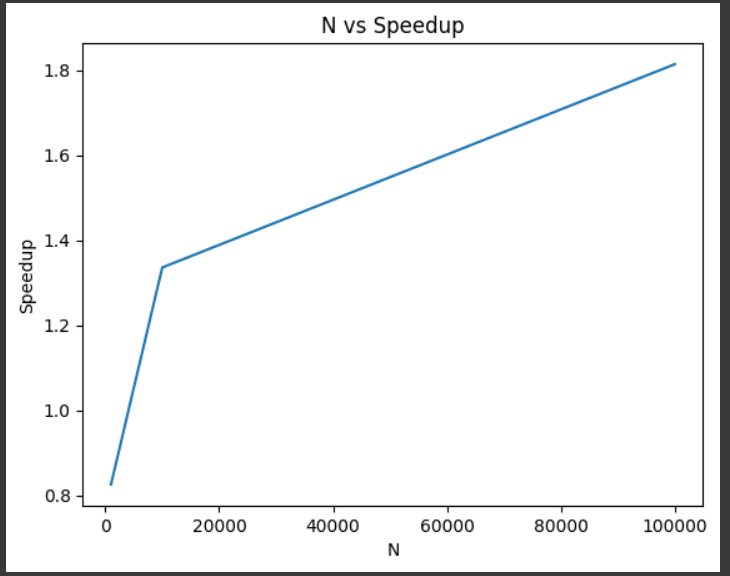

*Processing elements*: 3 <br>CPU times: user 2.22 s, sys: 191 ms, total: 2.42 s
Wall time: 6.31 s

*Processing elements* : 10 <br>
CPU times: user 290 ms, sys: 22.4 ms, total: 312 ms
Wall time: 3.67 s

*Processing elements*: 20 <br>
CPU times: user 2.03 s, sys: 183 ms, total: 2.21 s
Wall time: 5.29 s